<a href="https://colab.research.google.com/github/sunhuanhuan920/ECE1512_2023F_ProjectRepo_Zhenhuan_Sun/blob/main/Project%20A/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 1: Knowledge Distillation in MNIST Dataset**

# Question 1

(a). Transfer the knowledge from a large and cumbersome model to a model that is smaller and more suitable for deployment.

(b). The class probabilities produced by the cumbersome model.

(c).

\begin{equation}
\lim_{T \to \infty} \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)} = \frac{\exp(0)}{\sum_j \exp(0)} = \frac{1}{K}
\end{equation}

where $K$ denotes the number of classes. Thus, from this we can see that $T$ is a scaling factor that will make the probability distribution acorss all classes become closer to a uniform distribution.

We use $T$ to soften the probability distribution over classes, so that the class probabilities become less sharp and the differences in probabilities can be smoothed out.

By using a large value of $T$, the output class probabilities that used to be very small and have very little impact on the cross-entropy cost function will become larger and have a more pronounced impact on the cost function during knowledge distillation. As a result, the student model will focus not only on the class with highest confidence (probability) but also take into account the features that contribute to the confidence of other classes in the knowledge distillation process. Through this, the student model will be more capable of learning how the teacher model perceives the difference between classes, and the generaliztion capabilities of the teacher model.

(d). The loss function comprises two parts, the first part, which is called distillation loss, is defined as

\begin{equation}
L^{(distillation)}(\mathbf{x}|T) = -\sum_{i=1}^K q_i(\mathbf{x}|T) \log(p_i(\mathbf{x}|T))
\end{equation}

where $q_i(\mathbf{x}|T)$ is the softened probability for class $i$ given input vector $\mathbf{x}$ and distillation temperature $T$ from the teacher model, and $p_i(\mathbf{x}|T)$ is the student model's softened probability for class $i$ given same input vector and distillation temperature. Cross entropy is used to measure the difference between the student's softened probability distribution and the teacher's softened probability distribution over all classes.

The second part, which is sometimes referred as classification loss, is defined as

\begin{equation}
L^{(classification)}(\mathbf{x}|T=1) = -\sum_{i=1}^K y_i \log(p_i(\mathbf{x}|T=1))
\end{equation}

where $y_i$ is the $i$ th element of the one-hot vector. Cross entropy is used to measure the difference between student model's unsoftened ($T = 1$) predicted probability distribution for different classes and the true class probability distribution, e.g., one-hot vector.

The combined loss function is defined as

\begin{equation}
L(\mathbf{x}|T) = \lambda T^2 \cdot L^{(distillation)}(\mathbf{x}|T) + (1 - \lambda) \cdot L^{(classification)}(\mathbf{x}|1)
\end{equation}

where weight parameter ($\lambda$), i.e.,task balance parameter, is introduced to combined the distillation loss and classification loss. In addition, the distillation loss is scaled by a factor of $T^2$ in the weighted sum to compensate for the gradient's down scale by a factor of $1/T^2$ due to the present of $T$ in the softmax function.

The task balance parameter governs the relative contribution of distillation loss and classification loss in the overall kownledge distillation process. When $\lambda$ equals to 1, the student model focuses on distillation and is trained only using the kownledge from the teacher model. When $\lambda$ equals to 0, the student model is trained regularly using labeled data. By adjusting $\lambda$ between $0$ and $1$, we can control how much of the teacher model's knowledge versus the acutal data we want the student to focus on during its training.

(e). The use of soft targets allows student model to account for the relative probabilites of different classes in the teacher model's output and have a deeper understanding of how teacher model thinks and generalizes. Thus, by performing knowledge distillation from teacher model to student model, we are essentially letting teacher model to teach student model how to mimic its behavior to generalize as it does. This is equivalent to the effect of regularization, where we add regularization term to prevent model from memorizing the training data, so that the model can generalize well.

# Question 2

**Load Dataset**

In [3]:
# import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Union

# tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


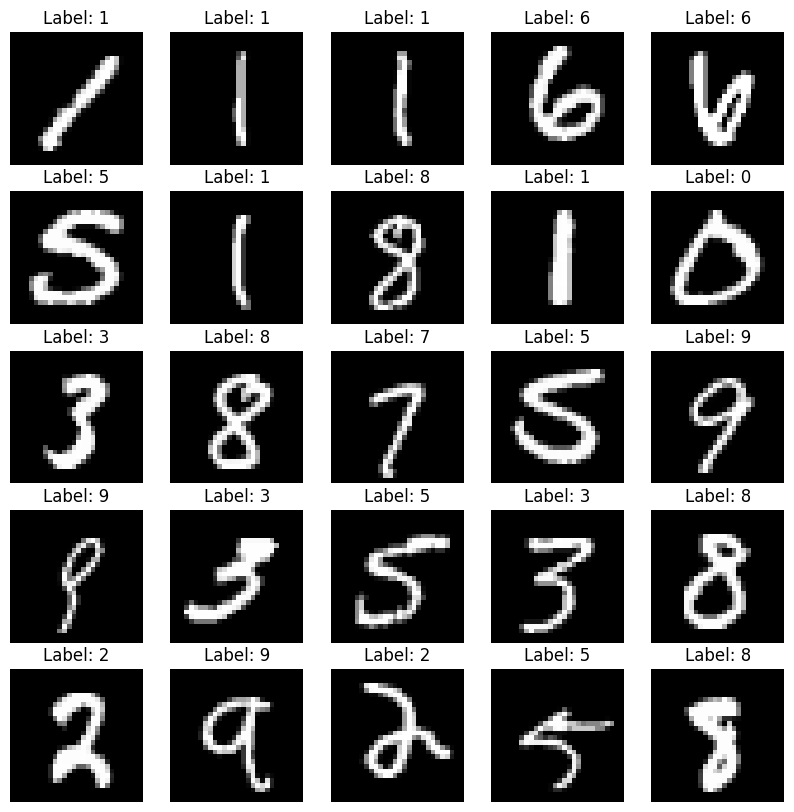

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from mnist_train
for images, labels in mnist_train.take(1):
    plt.figure(figsize=(10, 10))
    # Visualize the first 25 images from the batch
    for i in range(25):
        # print(images[i].shape)
        # print(labels[i].shape)
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title('Label: %d' % tf.argmax(labels[i]))
        plt.axis('off')
    plt.show()

**Model Creation**

In [5]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential([

    # Each image in MINIST dataset has shape of (28, 28, 1)
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),

    tf.keras.layers.Dropout(rate=0.5),
    # There are 10 classes in MINIST dataset
    tf.keras.layers.Dense(10)
])

# your code start from here for stpe 2


# Build fully connected student.
fc_model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(units=784, activation='relu'),

    tf.keras.layers.Dense(units=784, activation='relu'),

    # There are 10 classes in MINIST dataset
    tf.keras.layers.Dense(10)
])

# your code start from here for step 2

# Question 3

**Teacher loss function**

In [6]:
@tf.function
def compute_teacher_loss(images, labels):
    """Compute subclass knowledge distillation teacher loss for given images
       and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    subclass_logits = cnn_model(images, training=True)

    # your code start from here for step 3
    # Compute cross-entropy loss for subclasses.
    cross_entropy_loss_value = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)
    )

    return cross_entropy_loss_value

**Student loss function**

In [7]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.9 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 15. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    """Compute distillation loss.

    This function computes cross entropy between softened logits and softened
    targets. The resulting loss is scaled by the squared temperature so that
    the gradient magnitude remains approximately constant as the temperature is
    changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
    a neural network."

    Args:
      teacher_logits: A Tensor of logits provided by the teacher.
      student_logits: A Tensor of logits provided by the student, of the same
        shape as `teacher_logits`.
      temperature: Temperature to use for distillation.

    Returns:
      A scalar Tensor containing the distillation loss.
    """
    # your code start from here for step 3
    soft_targets = tf.nn.softmax(teacher_logits / temperature)

    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
    """Compute subclass knowledge distillation student loss for given images
      and labels.

    Args:
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Scalar loss Tensor.
    """
    student_subclass_logits = fc_model(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits = cnn_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Compute cross-entropy loss with hard targets.

    # your code start from here for step 3

    cross_entropy_loss_value = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
    )

    combined_loss = ALPHA * distillation_loss_value + (1 - ALPHA) * cross_entropy_loss_value

    return combined_loss

# Question 4

**Train and evaluation**

In [8]:
NUM_EPOCHS = 12

@tf.function
def compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
      model: Instance of tf.keras.Model.
      images: Tensor representing a batch of images.
      labels: Tensor representing a batch of labels.

    Returns:
      Number of correctly classified images.
    """
    class_logits = model(images, training=False)
    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
                tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
      model: Instance of tf.keras.Model.
      compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """

    # your code start from here for step 4
    # Initialize Adam optimizer with learning rate of 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(1, NUM_EPOCHS + 1):
      # Run training.
      print('Epoch {}: '.format(epoch), end='')
      for images, labels in mnist_train:
        # For backpropagation
        # Records the operations performed inside its block to compute gradients
        with tf.GradientTape() as tape:
          # your code start from here for step 4

          # Compute loss
          loss_value = compute_loss_fn(images, labels)

        # Use the recorded operations to compute the gradients
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Run evaluation.
      num_correct = 0
      num_total = builder.info.splits['test'].num_examples
      for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct_batch, _, _ = compute_num_correct(model, images, labels)
        num_correct += num_correct_batch
      print("Class_accuracy: " + '{:.2f}%'.format(
          num_correct / num_total * 100))

# Question 5

**Training models**

In [9]:
# your code start from here for step 5

# Train teacher model
print("Training Teacher Model")
train_and_evaluate(cnn_model, compute_teacher_loss)

# Train student model
print("\nTraining Student Model")
train_and_evaluate(fc_model, compute_student_loss)

Training Teacher Model
Epoch 1: 

Class_accuracy: 98.02%
Epoch 2: Class_accuracy: 98.67%
Epoch 3: Class_accuracy: 98.73%
Epoch 4: Class_accuracy: 98.99%
Epoch 5: Class_accuracy: 99.15%
Epoch 6: Class_accuracy: 98.94%
Epoch 7: Class_accuracy: 99.10%
Epoch 8: Class_accuracy: 99.14%
Epoch 9: Class_accuracy: 99.18%
Epoch 10: Class_accuracy: 99.15%
Epoch 11: Class_accuracy: 99.14%
Epoch 12: Class_accuracy: 99.21%

Training Student Model
Epoch 1: Class_accuracy: 96.57%
Epoch 2: Class_accuracy: 97.83%
Epoch 3: Class_accuracy: 98.14%
Epoch 4: Class_accuracy: 98.39%
Epoch 5: Class_accuracy: 98.43%
Epoch 6: Class_accuracy: 98.59%
Epoch 7: Class_accuracy: 98.65%
Epoch 8: Class_accuracy: 98.62%
Epoch 9: Class_accuracy: 98.68%
Epoch 10: Class_accuracy: 98.72%
Epoch 11: Class_accuracy: 98.73%
Epoch 12: Class_accuracy: 98.71%


# Question 6

**Test accuracy vs. tempreture curve**

In [10]:
# I modified the train_and_evaluate function to save and return the class accuracies
# obtained during evalution for all epoches
def train_and_evaluate_2(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
      model: Instance of tf.keras.Model.
      compute_loss_fn: A function that computes the training loss given the
        images, and labels.

    Returns:
      List of evaluation accuracies for each epoch.
    """
    epoch_accuracies = []

    # Initialize Adam optimizer with learning rate of 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(1, NUM_EPOCHS + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Run evaluation.
        num_correct = 0
        num_total = builder.info.splits['test'].num_examples
        for images, labels in mnist_test:
            num_correct_batch, _, _ = compute_num_correct(model, images, labels)
            num_correct += num_correct_batch
        accuracy = num_correct / num_total
        epoch_accuracies.append(accuracy)
        print("Class_accuracy: " + '{:.2f}%'.format(accuracy * 100))

    return epoch_accuracies


Training the student model with T = 1...
Epoch 1: Class_accuracy: 98.44%
Epoch 2: Class_accuracy: 98.79%
Epoch 3: Class_accuracy: 98.76%
Epoch 4: Class_accuracy: 98.59%
Epoch 5: Class_accuracy: 98.43%
Epoch 6: Class_accuracy: 98.75%
Epoch 7: Class_accuracy: 98.83%
Epoch 8: Class_accuracy: 98.72%
Epoch 9: Class_accuracy: 98.80%
Epoch 10: Class_accuracy: 98.78%
Epoch 11: Class_accuracy: 98.74%
Epoch 12: Class_accuracy: 98.65%
Average Test accuracy for T=1: 0.98690

Training the student model with T = 2...
Epoch 1: Class_accuracy: 98.64%
Epoch 2: Class_accuracy: 98.66%
Epoch 3: Class_accuracy: 98.88%
Epoch 4: Class_accuracy: 98.82%
Epoch 5: Class_accuracy: 98.94%
Epoch 6: Class_accuracy: 98.81%
Epoch 7: Class_accuracy: 98.82%
Epoch 8: Class_accuracy: 98.88%
Epoch 9: Class_accuracy: 98.74%
Epoch 10: Class_accuracy: 98.85%
Epoch 11: Class_accuracy: 98.93%
Epoch 12: Class_accuracy: 98.96%
Average Test accuracy for T=2: 0.98827

Training the student model with T = 4...
Epoch 1: Class_accurac

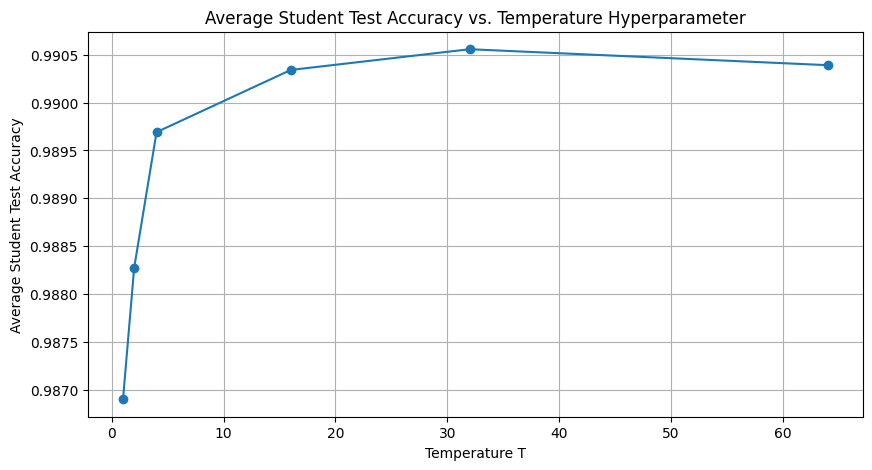

In [11]:
ALPHA = 0.5
temperatures = [1, 2, 4, 16, 32, 64]
accuracies = []

for T in temperatures:
    # Set global DISTILLATION_TEMPERATURE
    DISTILLATION_TEMPERATURE = T

    # Train and evaluate student model
    print(f"\nTraining the student model with T = {T}...")
    epoch_accuracies = train_and_evaluate_2(fc_model, compute_student_loss)

    # Compute the average accuracy over all epochs for this temperature
    avg_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)
    accuracies.append(avg_accuracy)
    print(f"Average Test accuracy for T={T}: {avg_accuracy:.5f}")

# Plotting the curve
plt.figure(figsize=(10, 5))
plt.plot(temperatures, accuracies, marker='o')
plt.xlabel('Temperature T')
plt.ylabel('Average Student Test Accuracy')
plt.title('Average Student Test Accuracy vs. Temperature Hyperparameter')
plt.grid(True)
plt.show()

The plot indicates that, in general, as the value of temperature hyperparameter increases, the average test accuracy over all epoches also increases. This align with our expectations as increasing temperature $T$ will allow student model to learn more from the teacher model about how it generalizes. Thus, the test accuracies increase accordingly.

# Question 7

**Train student from scratch**

In [12]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(units=784, activation='relu'),

    tf.keras.layers.Dense(units=784, activation='relu'),

    # There are 10 classes in MINIST dataset
    tf.keras.layers.Dense(10)
])

# your code start from here for step 7


def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
  )

  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.58%
Epoch 2: Class_accuracy: 96.96%
Epoch 3: Class_accuracy: 98.15%
Epoch 4: Class_accuracy: 97.96%
Epoch 5: Class_accuracy: 98.16%
Epoch 6: Class_accuracy: 97.86%
Epoch 7: Class_accuracy: 98.18%
Epoch 8: Class_accuracy: 98.05%
Epoch 9: Class_accuracy: 98.17%
Epoch 10: Class_accuracy: 98.18%
Epoch 11: Class_accuracy: 98.06%
Epoch 12: Class_accuracy: 97.96%


The student model with knowledge distillation outperform the student model without knowledge distillation in terms of test accuracy by a small margin.

# Question 8

**Comparing the teacher and student model (number of of parameters and FLOPs)**

In [ ]:
# Number of parameter comparison

# **Task 2: Knowledge Distillation in MHIST Dataset**